In [153]:
# Import the machine learning libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [154]:
!pip install eli5

In [155]:
import eli5
from eli5.sklearn import PermutationImportance

In [156]:
!pip install shap

In [157]:
import shap

In [158]:
!pip install pdpbox

In [159]:
from pdpbox import pdp, info_plots

In [160]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [161]:
# Load the Heart Disease dataset.
# The dataset can be downloaded here: https://archive.ics.uci.edu/ml/datasets/Heart+Disease
# Rename processed.cleveland.data to cleveland.csv.
df = pd.read_csv('/content/drive/My Drive/ML_Code/Heart Disease/cleveland.csv', header = None)

df.columns = ['age', 'sex', 'cp', 'trestbps', 'chol',
              'fbs', 'restecg', 'thalach', 'exang', 
              'oldpeak', 'slope', 'ca', 'thal', 'target']

**age**: The person's age in years<br>
**sex**: The person's sex (1 = male, 0 = female)<br>
**cp**: The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)<br>
**trestbps**: The person's resting blood pressure (mm Hg on admission to the hospital)<br>
**chol**: The person's cholesterol measurement in mg/dl<br>
**fbs**: The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)<br>
**restecg**: Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)<br>
**thalach**: The person's maximum heart rate achieved<br>
**exang**: Exercise induced angina (1 = yes; 0 = no)<br>
**oldpeak**: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more here)<br>
**slope**: the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)<br>
**ca**: The number of major vessels (0-3)<br>
**thal**: A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)<br>
**target**: Diagnosis of heart disease (angiographic disease status)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-- Value 0: < 50% diameter narrowing<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-- Value 1: > 50% diameter narrowing<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(in any major vessel: attributes 59 through 68 are vessels)

In [162]:
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
5,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
6,62.0,0.0,4.0,140.0,268.0,0.0,2.0,160.0,0.0,3.6,3.0,2.0,3.0,3
7,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,0
8,63.0,1.0,4.0,130.0,254.0,0.0,2.0,147.0,0.0,1.4,2.0,1.0,7.0,2
9,53.0,1.0,4.0,140.0,203.0,1.0,2.0,155.0,1.0,3.1,3.0,0.0,7.0,1


In [163]:
df.tail(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
293,63.0,1.0,4.0,140.0,187.0,0.0,2.0,144.0,1.0,4.0,1.0,2.0,7.0,2
294,63.0,0.0,4.0,124.0,197.0,0.0,0.0,136.0,1.0,0.0,2.0,0.0,3.0,1
295,41.0,1.0,2.0,120.0,157.0,0.0,0.0,182.0,0.0,0.0,1.0,0.0,3.0,0
296,59.0,1.0,4.0,164.0,176.0,1.0,2.0,90.0,0.0,1.0,2.0,2.0,6.0,3
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


In [164]:
# Unknown values '?' are included.
# Change unrecognized value '?' into mean value through the column.
for c in df.columns[:-1]:
    df[c] = df[c].apply(lambda x: df[df[c]!='?'][c].astype(float).mean() if x == "?" else x)
    df[c] = df[c].astype(float)

In [165]:
"""
for c in df.columns[:-1]:
  for r in range(len(df[c])):
    if df[c][r] == '?':
      df[c][r] = ''
"""

"\nfor c in df.columns[:-1]:\n  for r in range(len(df[c])):\n    if df[c][r] == '?':\n      df[c][r] = ''\n"

In [166]:
df.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.000000,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.000000,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.000000,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.000000,3.0,1
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,0.672241,3.0,0


In [167]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [168]:
df['target'] = df.target.map({0: 0, 1: 1, 2: 1, 3: 1, 4: 1})

In [169]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.931209,1.933272,0.499120
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


<Figure size 720x720 with 0 Axes>

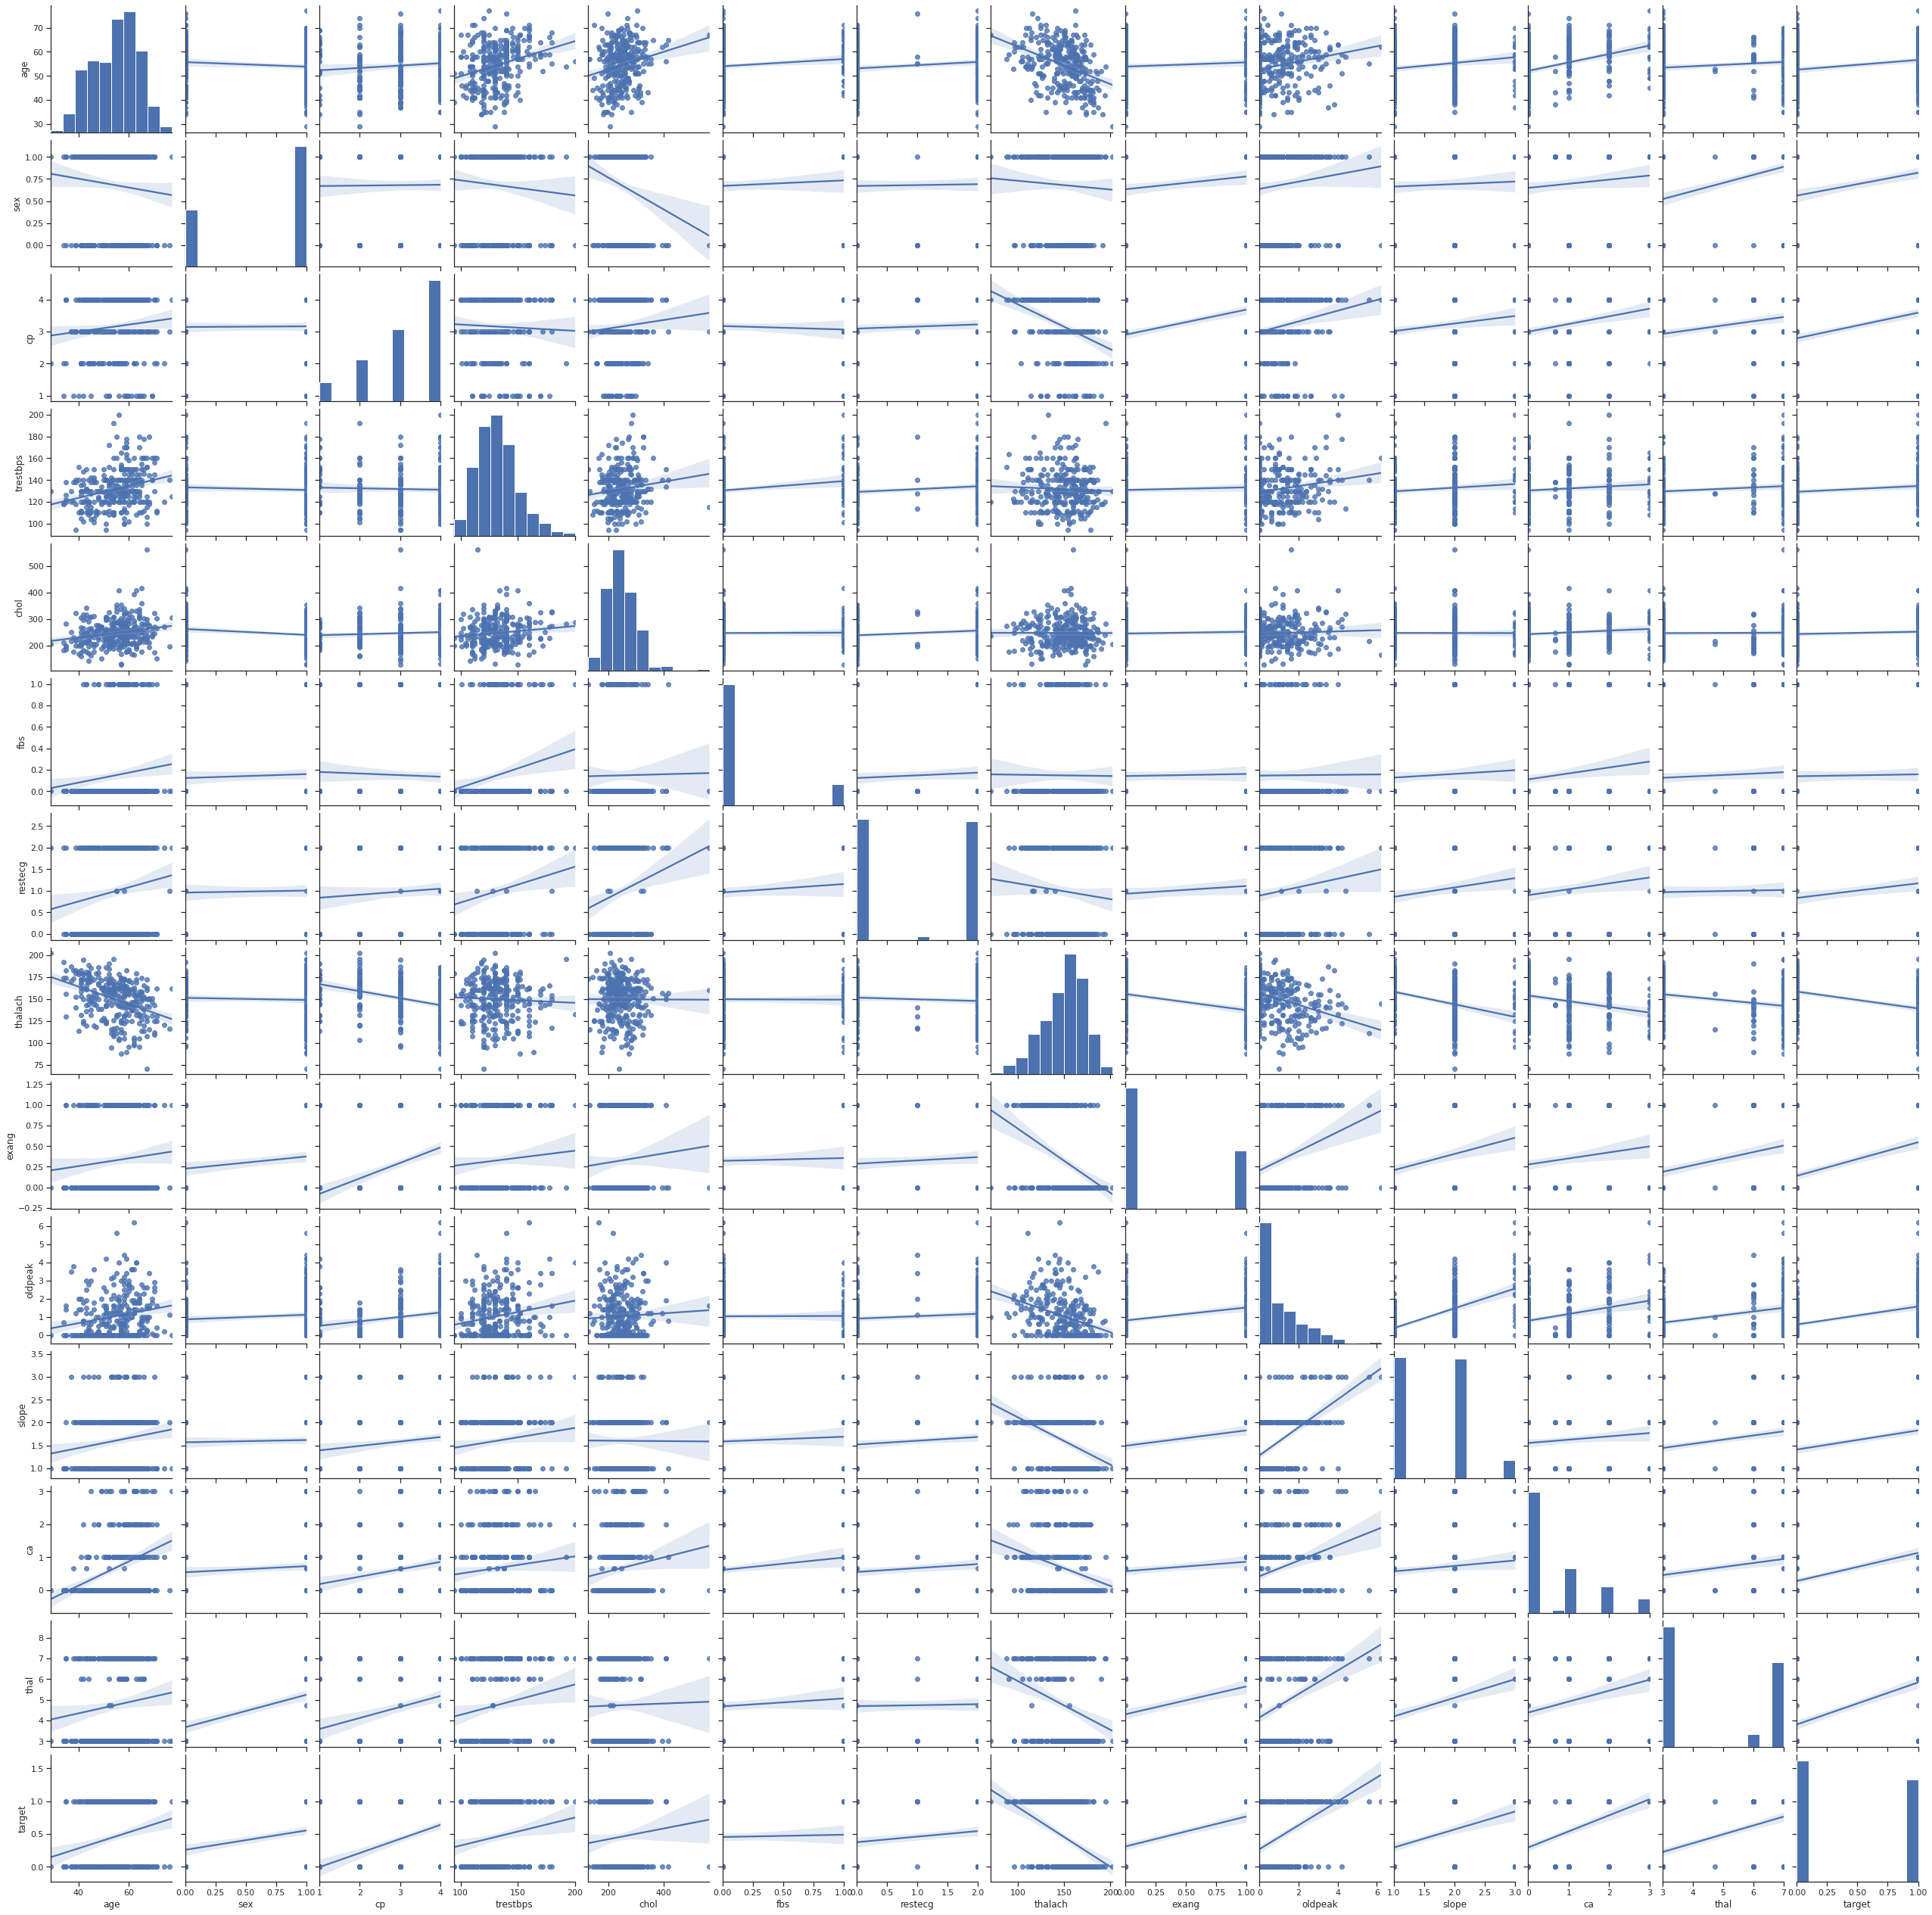

CPU times: user 1min 19s, sys: 17.6 s, total: 1min 37s
Wall time: 1min 16s


In [170]:
# Make a paiwise scatter plot.
%%time
plt.figure(figsize=(10, 10))
sns.set(style="ticks", color_codes=True)
sns.pairplot(df, kind="reg")
plt.show()

In [171]:
# Display correlation matrix.
cor = df.corr()
cor

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.097542,0.104139,0.284946,0.208950,0.118530,0.148868,-0.393806,0.091661,0.203805,0.161770,0.359489,0.127368,0.223120
sex,-0.097542,1.000000,0.010084,-0.064456,-0.199915,0.047862,0.021647,-0.048663,0.146201,0.102173,0.037533,0.092891,0.379300,0.276816
cp,0.104139,0.010084,1.000000,-0.036077,0.072319,-0.039975,0.067505,-0.334422,0.384060,0.202277,0.152050,0.232332,0.264895,0.414446
trestbps,0.284946,-0.064456,-0.036077,1.000000,0.130120,0.175340,0.146560,-0.045351,0.064762,0.189171,0.117382,0.098707,0.133534,0.150825
chol,0.208950,-0.199915,0.072319,0.130120,1.000000,0.009841,0.171043,-0.003432,0.061310,0.046564,-0.004062,0.118525,0.014190,0.085164
fbs,0.118530,0.047862,-0.039975,0.175340,0.009841,1.000000,0.069564,-0.007854,0.025665,0.005747,0.059894,0.143967,0.070658,0.025264
restecg,0.148868,0.021647,0.067505,0.146560,0.171043,0.069564,1.000000,-0.083389,0.084867,0.114133,0.133946,0.127487,0.024449,0.169202
thalach,-0.393806,-0.048663,-0.334422,-0.045351,-0.003432,-0.007854,-0.083389,1.000000,-0.378103,-0.343085,-0.385601,-0.263408,-0.278530,-0.417167
exang,0.091661,0.146201,0.384060,0.064762,0.061310,0.025665,0.084867,-0.378103,1.000000,0.288223,0.257748,0.144722,0.328291,0.431894
oldpeak,0.203805,0.102173,0.202277,0.189171,0.046564,0.005747,0.114133,-0.343085,0.288223,1.000000,0.577537,0.294558,0.340549,0.424510


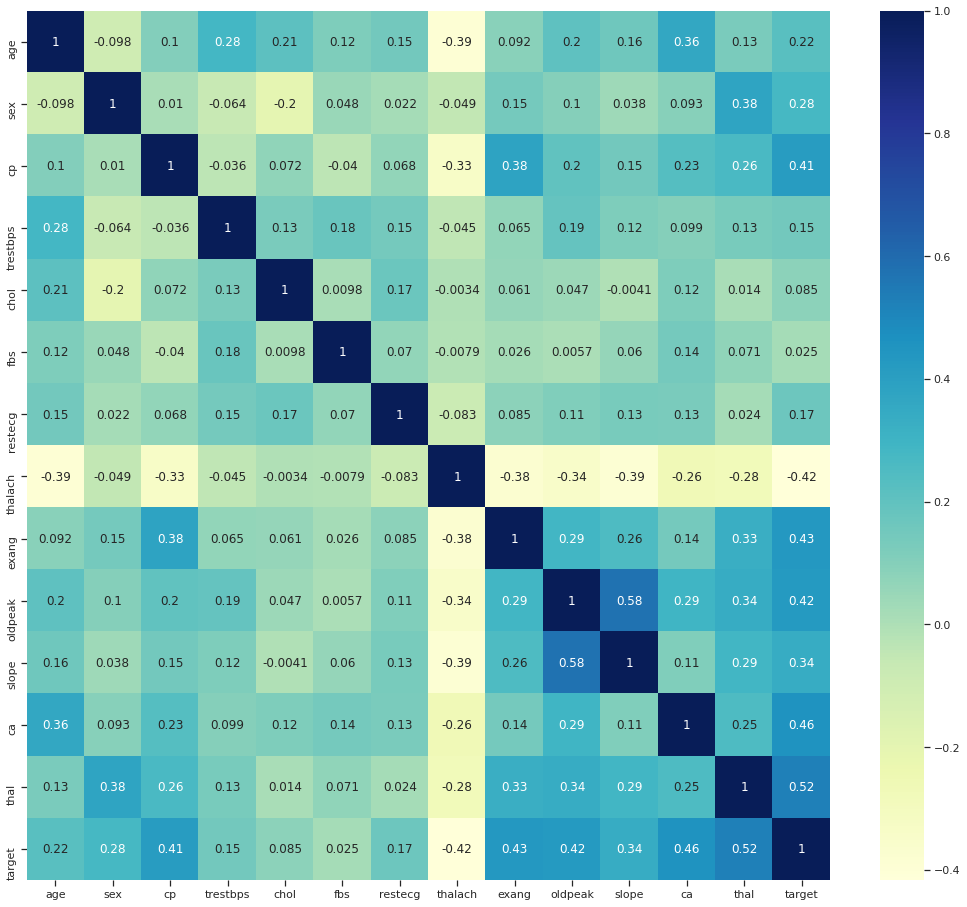

In [172]:
# Plot correlations on a heatmap.
plt.figure(figsize=(18,16))
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

<class 'pandas.core.series.Series'>
Number of Benign:  164
Number of Malignant :  139


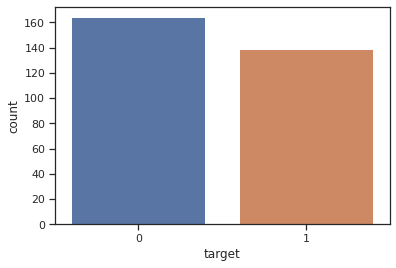

In [173]:
# y includes our labels and x includes our features
y = df['target']
print(type(y))
ax = sns.countplot(y, label="Count")
B, M = y.value_counts()
print('Number of Benign: ', B)
print('Number of Malignant : ', M)

In [174]:
X = df.drop('target', 1)
print(type(X))

<class 'pandas.core.frame.DataFrame'>


In [175]:
"""
from sklearn.preprocessing import StandardScaler
# Standardize features
scaler = StandardScaler() # z = (x - u) / s
X_scaled = scaler.fit_transform(X)
"""
# Standardize features
X_scaled = (X - X.mean()) / (X.std()) 
print(type(X_scaled))

<class 'pandas.core.frame.DataFrame'>


In [176]:
# Split the dataset into the training set and test subsets.
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = .3, random_state=7)

### **Random Forest**

In [177]:
# Run the random forest with default parameters.
rfc = RandomForestClassifier(max_depth=5)

In [178]:
# Fit the random forest model.
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [179]:
# Make predictions.
y_pred = rfc.predict(X_test)
y_pred_quant = rfc.predict_proba(X_test)[:, 1]

In [180]:
# Print classification report.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.95      0.81        41
           1       0.94      0.68      0.79        50

    accuracy                           0.80        91
   macro avg       0.83      0.82      0.80        91
weighted avg       0.84      0.80      0.80        91



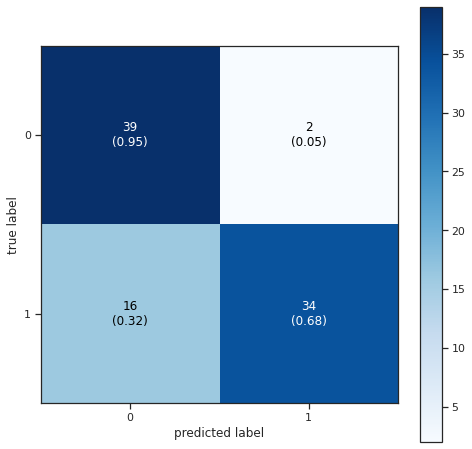

In [181]:
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
# Plot the confusion matrix.
cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
plot_confusion_matrix(conf_mat=cm,
                      show_absolute=True,
                      show_normed=True,
                      colorbar=True,
                      figsize=(8,8))
plt.show()

In [182]:
# Print accuracy.
print("Accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")

Accuracy: 0.8021978021978022 



AUC: 0.815609756097561 



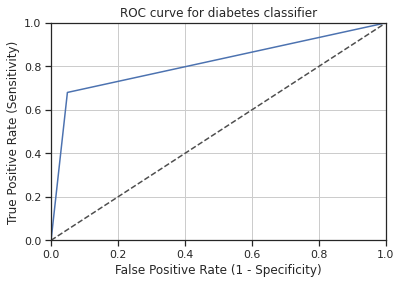

In [183]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
# Print Area Under the Curve (AUC).
print("AUC:", auc(fpr, tpr), "\n")

AUC: 0.9317073170731707 



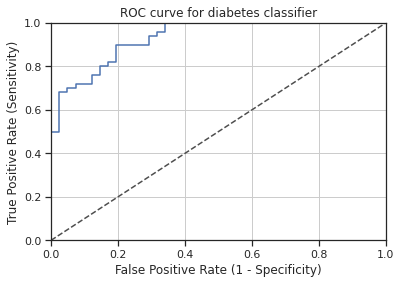

In [184]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
# Print Area Under the Curve (AUC).
print("AUC:", auc(fpr, tpr), "\n")

### **Multi-Layer Perceptron (MLP) with Grid Search**

In [186]:
# Specify range of hyperparameters for MLP models.
params_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.05],
    'hidden_layer_sizes': [(100,50,10), (200,100,50), (500,250,50), (100,), (200,), (300,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant','adaptive'],
}

In [187]:
%%time
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV

# Create a KFold object with 5 splits.
folds = KFold(n_splits=5, shuffle=True, random_state=0)

# Set the parameters by cross-validation.
# Set up GridSearchCV() funcion.
mlp_model = GridSearchCV(MLPClassifier(), params_grid, scoring='accuracy', cv=folds)
mlp_model.fit(X_train, y_train)

CPU times: user 19min 38s, sys: 9min 46s, total: 29min 25s
Wall time: 14min 53s


In [188]:
# Print the accuracy score.
print('Best score for the training data:', mlp_model.best_score_, '\nusing', mlp_model.best_params_)

Best score for the training data: 0.8539313399778516 
using {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50, 10), 'learning_rate': 'constant', 'solver': 'sgd'}


In [189]:
X_test.shape

(91, 13)

In [190]:
perm = PermutationImportance(mlp_model, random_state=7).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0462 ± 0.0580,thal
0.0286 ± 0.0769,ca
0.0022 ± 0.0292,exang
0.0022 ± 0.0164,trestbps
0.0022 ± 0.0164,sex
0.0000 ± 0.0139,slope
0 ± 0.0000,fbs
-0.0066 ± 0.0176,thalach
-0.0088 ± 0.0292,cp
-0.0110 ± 0.0311,oldpeak


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


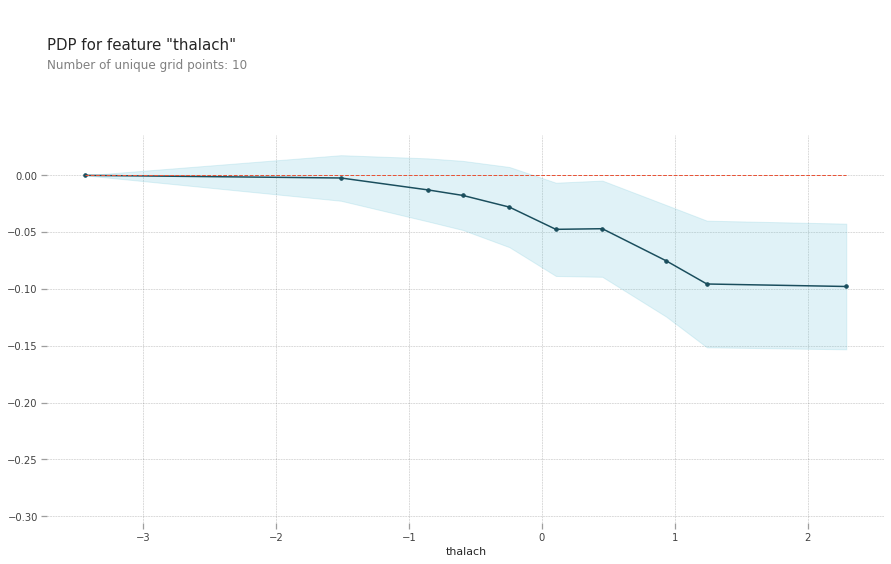

In [191]:
base_features = df.columns.values.tolist()
base_features.remove('target')

# Partial dependence plots show how a feature affects predictions.
# Partial dependence plots are calculated after a model has been fit.
# the number of major blood vessels increases, the probability of heart disease decreases.
feat_name = 'thalach'
pdp_dist = pdp.pdp_isolate(model=rfc, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

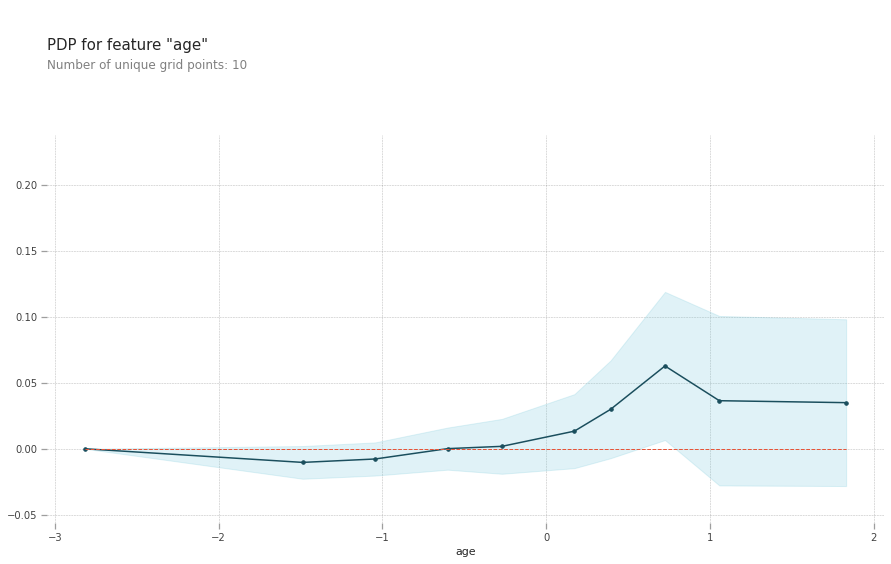

In [192]:
feat_name = 'age'
pdp_dist = pdp.pdp_isolate(model=rfc, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

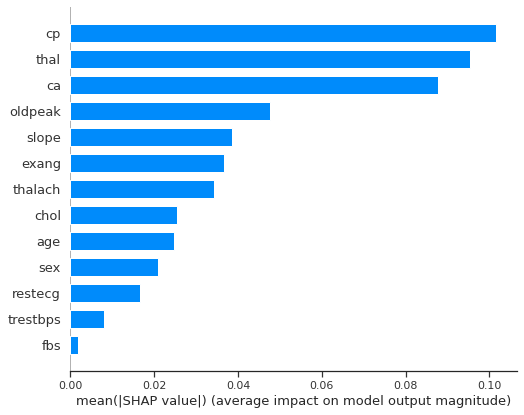

In [193]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")

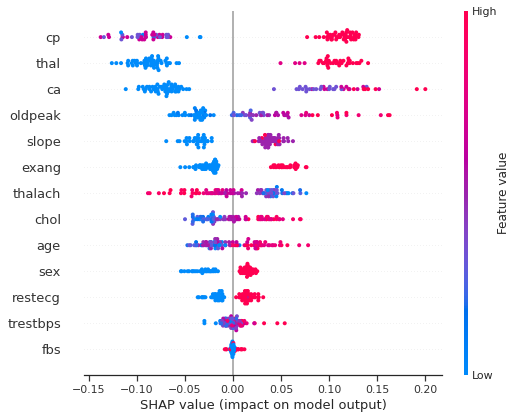

In [194]:
shap.summary_plot(shap_values[1], X_test)

In [195]:
def heart_disease_risk_factors(model, patient):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient)

In [196]:
data_for_prediction = X_test.iloc[1,:].astype(float)
heart_disease_risk_factors(rfc, data_for_prediction)